In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sms-spam-collection-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F483%2F982%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240311%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240311T083018Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dcb2f54656fadd1b22fe13599769b6dff90d868b44b22feb78a29986dde186a4cdbd910ba2d56a89c60c9bae6e94f5e1b5cb68a6343b56e181d53fa4301fa30acb978c739edde270754fea3dccc190062a3b07fdc7dee19905cd2557d96b15e5f6047f06335fad482004f6642226b19e563743ea2d8e72a821bc28ccb035657f6a03f1eb33d8e4ecb47e26113b1862f155615e917ee7fb860b9d1fd7dec04bea8cee3a7943d95e8f19bcc172f128eb7bfae6b013f741d758d20d3460b70fae4593afcf48b526aac113a20c72868af9fa7367d1b96ef260bef1da0d86cbb4d20014e982cbeee93d42085a284ceb7fd077b4a19f12e0d3084bb4e6fea8d422e7131'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 215934 bytes downloaded
Downloaded and uncompressed: sms-spam-collection-dataset
Data source import complete.


# Important Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

from wordcloud import WordCloud
import os

# Reading & Exploring Data

In [3]:
data = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding='latin1')

In [4]:
data.head

<bound method NDFrame.head of         v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN  
1           NaN        NaN  
2           NaN        NaN  
3           NaN        NaN  
4           NaN        NaN  
...         ...        ...  
5567        NaN        NaN  
5568        NaN        NaN  
5569        NaN        NaN  
5570        NaN        NaN  
5571        NaN        NaN  

[5572 rows x 5 columns]>

In [5]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [6]:
data.v1

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: v1, Length: 5572, dtype: object

In [7]:
data.v2

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, Length: 5572, dtype: object

In [8]:
data['Unnamed: 2']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
5567    NaN
5568    NaN
5569    NaN
5570    NaN
5571    NaN
Name: Unnamed: 2, Length: 5572, dtype: object

In [9]:
data['Unnamed: 3']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
5567    NaN
5568    NaN
5569    NaN
5570    NaN
5571    NaN
Name: Unnamed: 3, Length: 5572, dtype: object

In [10]:
data['Unnamed: 4']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
5567    NaN
5568    NaN
5569    NaN
5570    NaN
5571    NaN
Name: Unnamed: 4, Length: 5572, dtype: object

# Simple Preprocessing

In [11]:
# Renaming the important columns to be more understandable
data = data.rename(columns={'v1': 'is_ham', 'v2': 'text'})

# Selecting only important columns
data=data.iloc[:, :2]

# Encoding the label
data['is_ham'] = (data['is_ham'] == 'ham').astype(int)

data

,is_ham,text
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,0,This is the 2nd time we have tried 2 contact u...
5568,1,Will Ì_ b going to esplanade fr home?
5569,1,"Pity, * was in mood for that. So...any other s..."
5570,1,The guy did some bitching but I acted like i'd...


In [12]:
data.is_ham.value_counts()

1    4825
0     747
Name: is_ham, dtype: int64

In [13]:
# Splitting the data

x_train, x_test, y_train, y_test = train_test_split(data.text, data.is_ham, train_size=0.8, shuffle=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4457,), (1115,), (4457,), (1115,))

# Impilmenting BOW Representation

In [14]:
# Creating an Instance of the CountVectorizer
count_vectorizer = CountVectorizer()

In [15]:
type(x_train), type(x_train.values)

(pandas.core.series.Series, numpy.ndarray)

In [16]:
x_train_count_vectorizer = count_vectorizer.fit_transform(x_train.values)
x_train_count_vectorizer

<4457x7690 sparse matrix of type '<class 'numpy.int64'>'
	with 59250 stored elements in Compressed Sparse Row format>

In [17]:
x_train_cv = x_train_count_vectorizer.toarray()
x_train_cv

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
x_train_cv.shape

(4457, 7690)

In [19]:
count_vectorizer.vocabulary_

{'ok': 4888,
 'want': 7307,
 'to': 6883,
 'be': 1257,
 'inside': 3669,
 'you': 7639,
 'every': 2653,
 'night': 4745,
 'come': 1886,
 'around': 1057,
 'lt': 4217,
 'decimal': 2191,
 'gt': 3247,
 'pm': 5232,
 'vikky': 7226,
 'otside': 4972,
 'nw': 4838,
 'il': 3598,
 'by': 1573,
 'tht': 6830,
 'time': 6851,
 'oh': 4883,
 'dang': 2144,
 'didn': 2287,
 'mean': 4381,
 'send': 5964,
 'that': 6759,
 'lol': 4157,
 'home': 3461,
 'so': 6234,
 'we': 7344,
 'can': 1612,
 'always': 913,
 'chat': 1725,
 've': 7195,
 'sent': 5974,
 'ì_': 7678,
 'my': 4633,
 'part': 5057,
 'great': 3219,
 'princess': 5377,
 'love': 4197,
 'giving': 3136,
 'and': 944,
 'receiving': 5587,
 'oral': 4945,
 'doggy': 2372,
 'style': 6506,
 'is': 3726,
 'fave': 2779,
 'position': 5288,
 'how': 3506,
 'about': 735,
 'enjoy': 2579,
 'making': 4302,
 'times': 6852,
 'per': 5117,
 'sir': 6138,
 'need': 4700,
 'velusamy': 7201,
 'date': 2160,
 'of': 4864,
 'birth': 1351,
 'company': 1904,
 'bank': 1210,
 'facilities': 2731,
 'de

# Creating the Classifier

In [20]:
model = MultinomialNB()
model

MultinomialNB()

In [21]:
model.fit(x_train_cv, y_train)

MultinomialNB()

In [22]:
x_test_cv = count_vectorizer.transform(x_test).toarray()
x_test_cv

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [23]:
y_pred = model.predict(x_test_cv)
y_pred

array([1, 1, 1, ..., 0, 1, 1])

# Evaluating the Model

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       150
           1       0.98      1.00      0.99       965

    accuracy                           0.98      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



# Some Cool Visualization

In [25]:
email = data.iloc[0].text
print(email)

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


In [26]:
mail_word_cloud = WordCloud(width=512, height=512).generate(email.replace('.', ''))

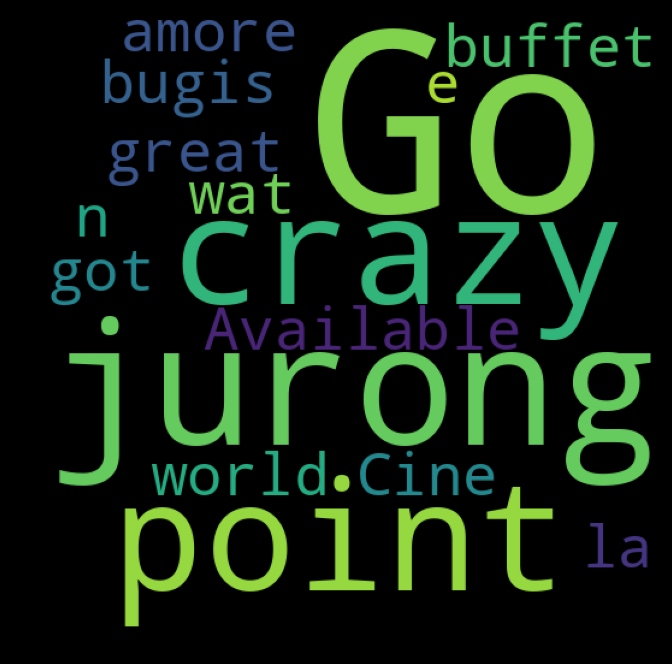

In [27]:
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(mail_word_cloud)

In [28]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 6.6 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size

In [29]:
import gradio as gr

In [53]:
def check_message(message):
    message_cv = count_vectorizer.transform([message]).toarray()
    prediction = "Ham" if model.predict(message_cv)[0] == 1 else "Spam"

    figure = plt.figure(figsize = (10, 8), facecolor = 'k')
    plt.imshow(WordCloud(width=512, height=512).generate(message.replace('.', '')))

    return figure, prediction

(<Figure size 1000x800 with 1 Axes>, 'Ham')

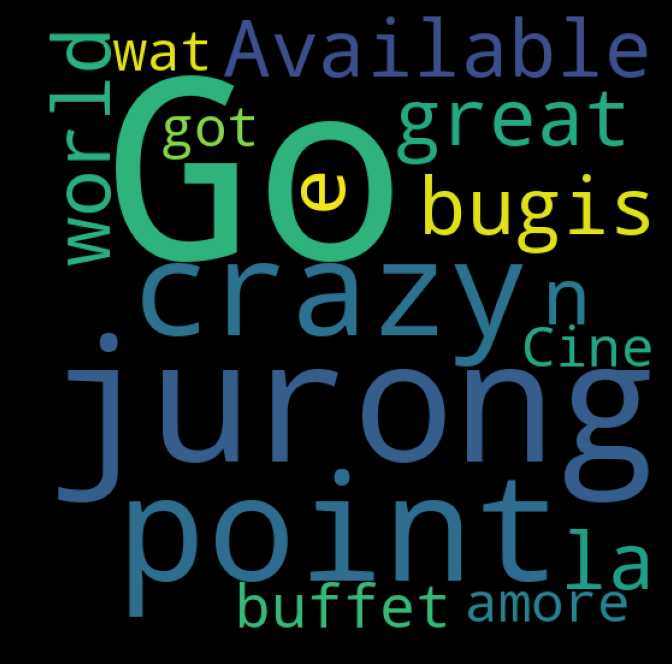

In [54]:
check_message("Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...")

In [55]:
interface = gr.Interface(check_message, inputs=gr.Textbox(label="Message", placeholder="Write a text message...", max_lines=10), outputs=[gr.Plot(label=' '), gr.Text(label=' ')])

In [56]:
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ae16fd7f6219ac5f3e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
